# SINGLE FEATURE PREDICTION USING THE SAME SINGLE FEATURE WITH LSTM SEQ2SEQ
## HERE WE USED: 12h for running the inference over the next 1h

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from keras.models import Sequential, save_model, load_model
from keras.layers import Bidirectional, LSTM, Dropout, Dense
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_percentage_error
import os
import time
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from tensorflow.keras.layers import BatchNormalization, ConvLSTM2D, RepeatVector
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from tensorflow.keras.layers import TimeDistributed

import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

models_path = "../saved_models/normal/may2023"
# read dataset may2023
df = pd.read_pickle("../../data/20230319_RTU_Dataset_PPC-Lab/combined_may2023.pkl")  

2023-06-12 16:49:25.602150: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-12 16:49:25.631025: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Data Loader Parameters
BATCH_SIZE = 128
EPOCHS = 5
BUFFER_SIZE = 100

# LSTM Parameters
EVALUATION_INTERVAL = 200
PATIENCE = 5
PAST_WINDOW_SIZE = 144                    # ----------- 12H
FUTURE_WINDOW_SIZE = 12                   # ----------- 1H
STEP = 5

# Reproducibility
SEED = 13
tf.random.set_seed(SEED)

In [3]:
def create_sequence(dataset, target, window, future):
    x_sequence, y_sequence = [], []
    for index in range(len(dataset) - window - future):
        x_sequence.append(dataset[index: index + window])
        y_sequence.append(target[index + window: index + window + future])
    return (np.asarray(x_sequence), np.asarray(y_sequence))

def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

def multivariate_multioutput_data(dataset, target, start_index, end_index, history_size, target_size, step):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        labels.append(target[i:i+target_size])

    return np.array(data)[:,:,:,np.newaxis,np.newaxis], np.array(labels)[:,:,:,np.newaxis,np.newaxis]

def create_time_steps(length):
    return list(range(-length, 0))
    
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data)[:,:,np.newaxis], np.array(labels)[:,:,np.newaxis]

def evaluate_predictions(predictions_seq, y_test_seq):
    MSE = []
    for pred in range(len(y_test)):
        mse = mean_squared_error(y_test_seq[pred], predictions_seq[pred])
        MSE.append(mse)
    return MSE

def find_max_error(predictions, y_test, mean_mse, std_mse):
    max_errors = 0
    for pred in range(len(y_test)):
        mse = mean_squared_error(y_test[pred], predictions[pred])
    if mse > mean_mse + std_mse:
        max_errors += 1
    return max_errors

def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    plt.plot(num_in, history, label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()
    
def my_mean_absolute_percentage_error(y_true, y_pred):
    error = 0
    for i in range(len(y_true)):
        if y_true[i] != 0:
            error += abs((y_true[i] - y_pred[i]) / y_true[i])
    
    mape = (error / len(y_true)) * 100
    return mape

In [4]:
# Normalizing the values
standard_scaler = preprocessing.StandardScaler()
print(df.head())
scaled_df = standard_scaler.fit_transform(df[['MEM_USAGE', 'CPU_USAGE', 'TEMP']])
print(scaled_df[:10])
print(scaled_df[:,1])

training_size = int(len(scaled_df) * 0.8)

print('Size of the dataset: %d' % (len(scaled_df)))
print('Size of training: %d' % (training_size))


   MEM_USAGE  CPU_USAGE     PS1_V    TEMP
0  35.555417  27.343750  5.435294  28.687
1  35.555417   6.367041  5.435294  28.687
2  35.555417   7.142857  5.435294  28.687
3  35.555417  27.306273  5.435294  28.687
4  35.555417   5.639098  5.435294  28.687
[[ 0.48139574  1.13540371  0.74576055]
 [ 0.48139574 -0.66263387  0.74576055]
 [ 0.48139574 -0.59613411  0.74576055]
 [ 0.48139574  1.13219134  0.74576055]
 [ 0.48139574 -0.7250302   0.74576055]
 [ 0.48139574 -0.73742406  0.74576055]
 [ 0.48139574 -0.6369512   0.74576055]
 [ 0.48139574 -0.91168167  0.74576055]
 [ 0.48139574 -0.63268673  0.74576055]
 [ 0.48139574 -0.27087286  0.74576055]]
[ 1.13540371 -0.66263387 -0.59613411 ... -0.69409514 -0.51872237
 -0.07440583]
Size of the dataset: 3733
Size of training: 2986


In [5]:
scaled_df

array([[ 0.48139574,  1.13540371,  0.74576055],
       [ 0.48139574, -0.66263387,  0.74576055],
       [ 0.48139574, -0.59613411,  0.74576055],
       ...,
       [-1.80536352, -0.69409514,  0.98794801],
       [-1.80536352, -0.51872237,  0.98794801],
       [-1.80536352, -0.07440583,  0.98794801]])

# SINGLE FEATURE CPU

In [6]:
x_train_multi, y_train_multi = multivariate_data(scaled_df[:, 1], scaled_df[:, 1], 0,
                                                 training_size, PAST_WINDOW_SIZE,
                                                 FUTURE_WINDOW_SIZE, STEP)
x_val_multi, y_val_multi = multivariate_data(scaled_df[:, 1], scaled_df[:, 1],
                                             training_size, None, PAST_WINDOW_SIZE,
                                                 FUTURE_WINDOW_SIZE, STEP)

In [7]:
x_train_multi.shape

(2842, 29, 1)

In [8]:
y_train_multi.shape

(2842, 12, 1)

In [9]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

2023-06-12 16:49:29.158381: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-12 16:49:29.167343: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-12 16:49:29.167650: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [10]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(FUTURE_WINDOW_SIZE))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
print(multi_step_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 29, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 12)                204       
                                                                 
Total params: 7,692
Trainable params: 7,692
Non-trainable params: 0
_________________________________________________________________
None


2023-06-12 16:49:31.680216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 16:49:31.681233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 16:49:31.681805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [11]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

2023-06-12 16:49:32.902440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [591,12,1]
	 [[{{node Placeholder/_1}}]]
2023-06-12 16:49:33.128492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 16:49:33.129403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tenso

4/4 [==============================] - 1s 3ms/step
(128, 12)


2023-06-12 16:49:33.834912: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-12 16:49:33.919853: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900


In [12]:
EPOCHS = 10

early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
multi_step_history = multi_step_model.fit(train_data_multi,
                                          epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=EVALUATION_INTERVAL,
                                          callbacks=[early_stopping])

Epoch 1/10


2023-06-12 16:49:34.018191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [2842,12,1]
	 [[{{node Placeholder/_1}}]]
2023-06-12 16:49:34.131542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 16:49:34.132573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tens

197/200 [============================>.] - ETA: 0s - loss: 0.6459

2023-06-12 16:49:38.584175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [591,12,1]
	 [[{{node Placeholder/_1}}]]
2023-06-12 16:49:38.752614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 16:49:38.753286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tenso

200/200 [==============================] - 6s 22ms/step - loss: 0.6458 - val_loss: 0.6133
Epoch 2/10
200/200 [==============================] - 3s 17ms/step - loss: 0.6402 - val_loss: 0.6134
Epoch 3/10
200/200 [==============================] - 3s 17ms/step - loss: 0.6410 - val_loss: 0.6141
Epoch 4/10
200/200 [==============================] - 3s 17ms/step - loss: 0.6395 - val_loss: 0.6134


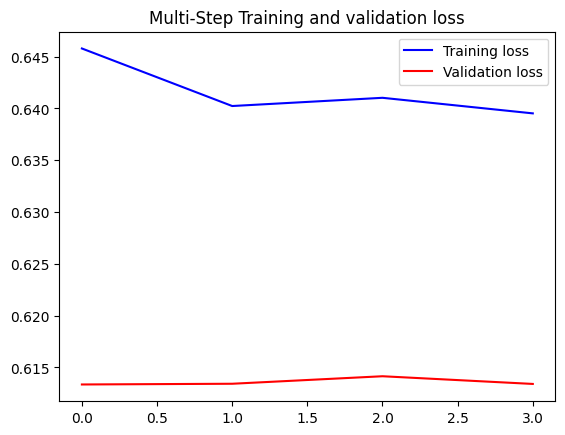

In [13]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [14]:
multi_step_model.save('best_single_feature_cpu.h5')

In [15]:
from tensorflow import keras
multi_step_model = keras.models.load_model("./best_single_feature_cpu.h5")

2023-06-12 16:52:44.796128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 16:52:44.796864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 16:52:44.797590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-12 16:53:20.950243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [591,12,1]
	 [[{{node Placeholder/_1}}]]
2023-06-12 16:53:21.117975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 16:53:21.118626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tenso

(128, 29, 1)
4/4 [==============================] - 0s 3ms/step
(128, 12)
4/4 [==============================] - 0s 3ms/step


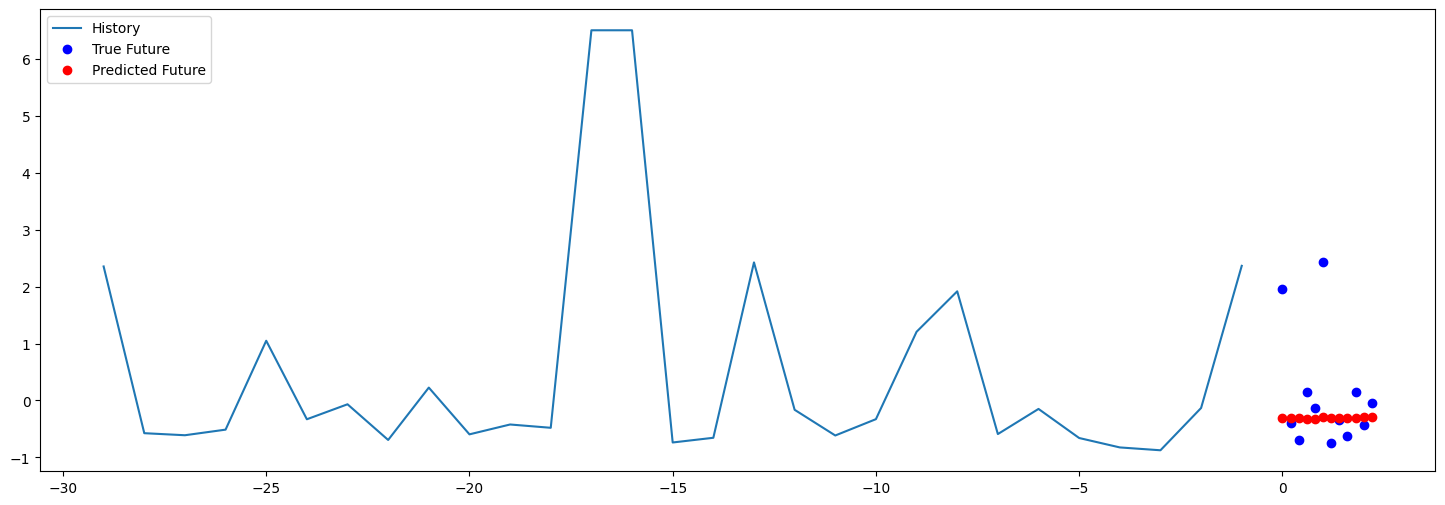

(128, 29, 1)
4/4 [==============================] - 0s 3ms/step
(128, 12)
4/4 [==============================] - 0s 6ms/step


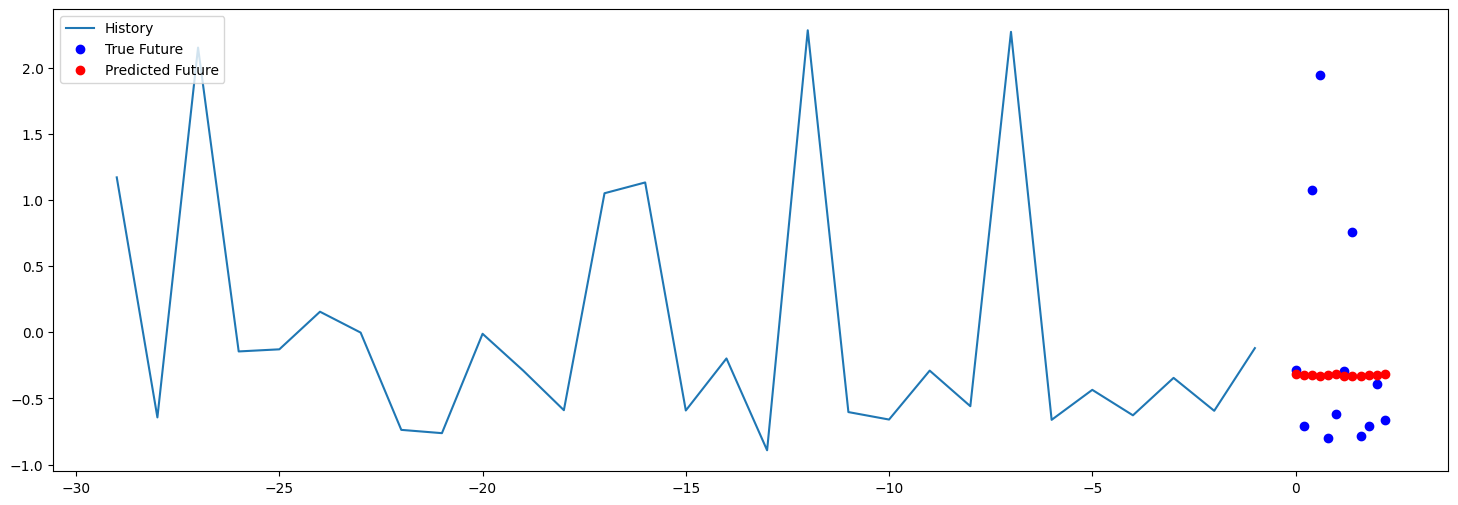

(128, 29, 1)
4/4 [==============================] - 0s 3ms/step
(128, 12)
4/4 [==============================] - 0s 3ms/step


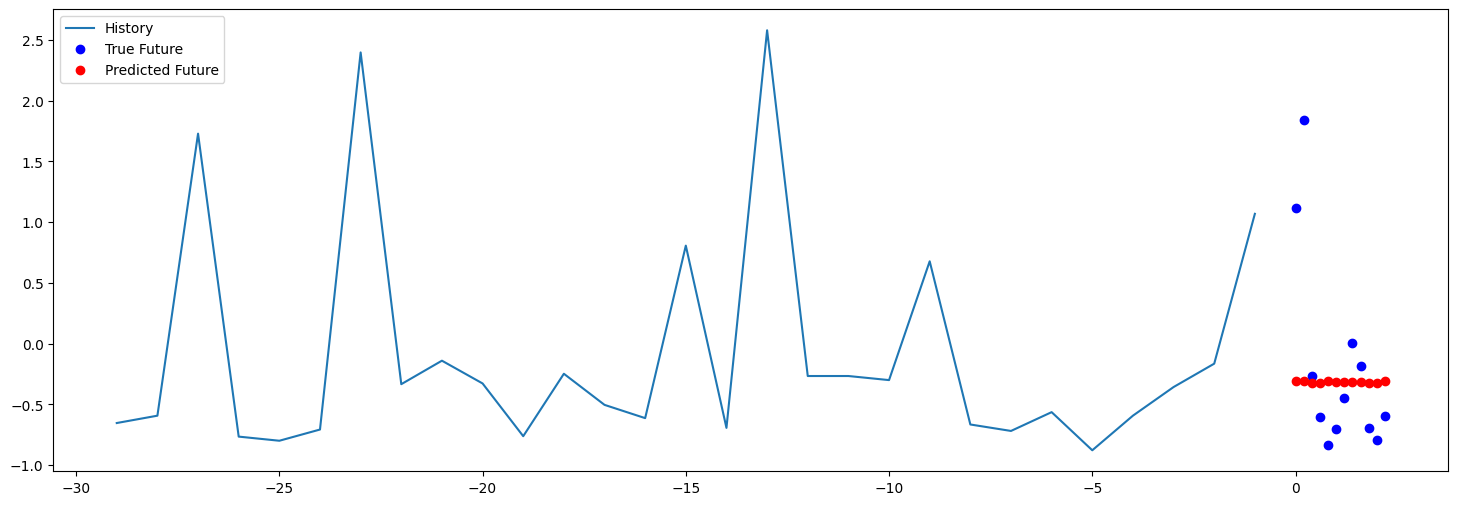

In [16]:
for x, y in val_data_multi.take(3):
    print(x.shape)
    print(multi_step_model.predict(x).shape)
    multi_step_plot(np.squeeze(x[0]), np.squeeze(y[0]), multi_step_model.predict(x)[0])

In [17]:
import tensorflow as tf
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().batch(BATCH_SIZE)
val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE)

predicted_cpus = []
original_cpus = []
history_cpus = []


for x, y in train_data_multi:
    hx_cpu = np.squeeze(x[0])
    history_cpus.append(hx_cpu)

for x, y in val_data_multi:
    prediction = multi_step_model.predict(x, verbose = 0)[0]
    ori_cpus = np.squeeze(y[0])
    
    predicted_cpus.append(prediction)
    original_cpus.append(ori_cpus)
    

predicted_cpu_usage = np.concatenate(predicted_cpus, axis=0)
original_cpu_usage = np.concatenate(original_cpus, axis=0)
history_cpu_usage = np.concatenate(history_cpus, axis=0)   

2023-06-12 16:53:24.179155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [2842,12,1]
	 [[{{node Placeholder/_1}}]]
2023-06-12 16:53:24.212459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [591,12,1]
	 [[{{node Placeholder/_1}}]]
2023-06-12 16:53:24.566182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/sp

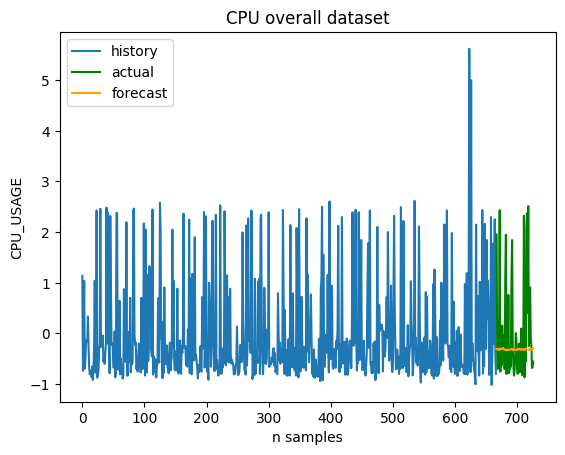

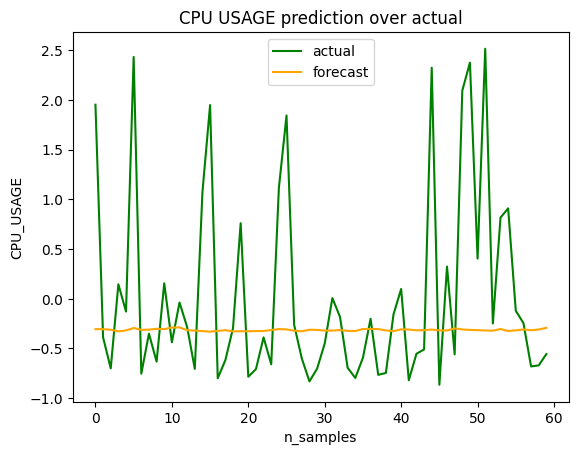

In [18]:
plt.title("CPU overall dataset") 
plt.xlabel("n samples") 
plt.ylabel("CPU_USAGE") 
plt.plot(range(len(history_cpu_usage)),history_cpu_usage, label="history") 
plt.plot(range(len(history_cpu_usage), len(history_cpu_usage) + len(predicted_cpu_usage)),original_cpu_usage, label="actual", color="green")
plt.plot(range(len(history_cpu_usage), len(history_cpu_usage) + len(predicted_cpu_usage)),predicted_cpu_usage, label="forecast" , color="orange")

plt.legend()
plt.show()

x = range(len(predicted_cpu_usage))
plt.title("CPU USAGE prediction over actual") 
plt.xlabel("n_samples") 
plt.ylabel("CPU_USAGE") 
plt.plot(x,original_cpu_usage, label="actual", color="green")
plt.plot(x,predicted_cpu_usage, label="forecast", color="orange")
plt.legend()


In [19]:
my_mean_absolute_percentage_error(original_cpu_usage, predicted_cpu_usage)

176.88683037125753

# SINGLE FEATURE RAM

In [20]:
x_train_multi, y_train_multi = multivariate_data(scaled_df[:, 0], scaled_df[:, 0], 0,
                                                 training_size, PAST_WINDOW_SIZE,
                                                 FUTURE_WINDOW_SIZE, STEP)
x_val_multi, y_val_multi = multivariate_data(scaled_df[:, 0], scaled_df[:, 0],
                                             training_size, None, PAST_WINDOW_SIZE,
                                                 FUTURE_WINDOW_SIZE, STEP)

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(FUTURE_WINDOW_SIZE))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
print(multi_step_model.summary())


EPOCHS = 10

early_stopping = EarlyStopping(monitor='val_loss', patience = EPOCHS, restore_best_weights=True)
multi_step_history = multi_step_model.fit(train_data_multi,
                                          epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=EVALUATION_INTERVAL,
                                          callbacks=[early_stopping])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 29, 32)            4352      
                                                                 
 lstm_3 (LSTM)               (None, 16)                3136      
                                                                 
 dense_1 (Dense)             (None, 12)                204       
                                                                 
Total params: 7,692
Trainable params: 7,692
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10


2023-06-12 16:53:31.618642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 16:53:31.619327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 16:53:31.620017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

197/200 [============================>.] - ETA: 0s - loss: 0.1627

2023-06-12 16:53:35.998273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [591,12,1]
	 [[{{node Placeholder/_1}}]]
2023-06-12 16:53:36.110875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 16:53:36.111670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tenso

200/200 [==============================] - 5s 18ms/step - loss: 0.1604 - val_loss: 2.3033
Epoch 2/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0772 - val_loss: 2.8955
Epoch 3/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0697 - val_loss: 2.9148
Epoch 4/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0586 - val_loss: 3.0884
Epoch 5/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0564 - val_loss: 2.6821
Epoch 6/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0479 - val_loss: 2.6095
Epoch 7/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0406 - val_loss: 2.6387
Epoch 8/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0400 - val_loss: 2.5333
Epoch 9/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0376 - val_loss: 2.5711
Epoch 10/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0352 - val_loss: 2.6220


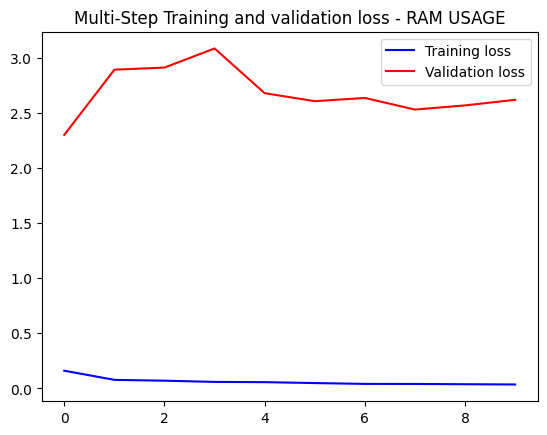

In [21]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss - RAM USAGE')

In [22]:
multi_step_model.save('best_single_feature_mem.h5')

In [23]:
from tensorflow import keras
multi_step_model = keras.models.load_model("./best_single_feature_mem.h5")

2023-06-12 16:54:07.747966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 16:54:07.748851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 16:54:07.749452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-12 16:54:21.117643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [591,12,1]
	 [[{{node Placeholder/_1}}]]
2023-06-12 16:54:21.281855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 16:54:21.282666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tenso

4/4 [==============================] - 0s 3ms/step


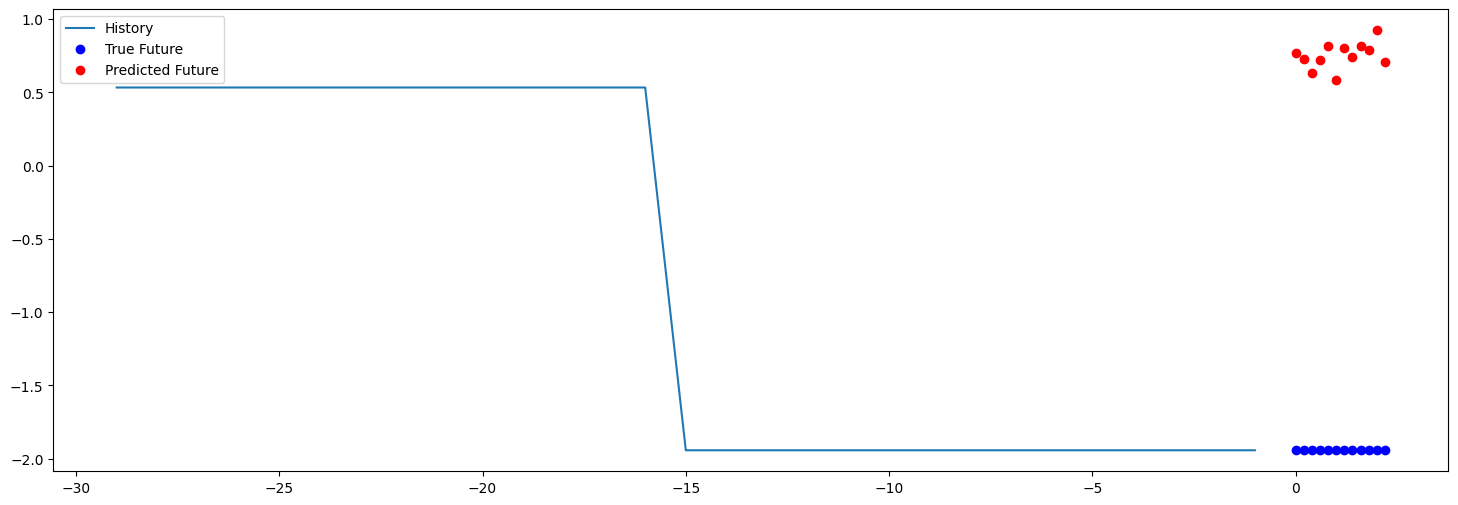

4/4 [==============================] - 0s 3ms/step


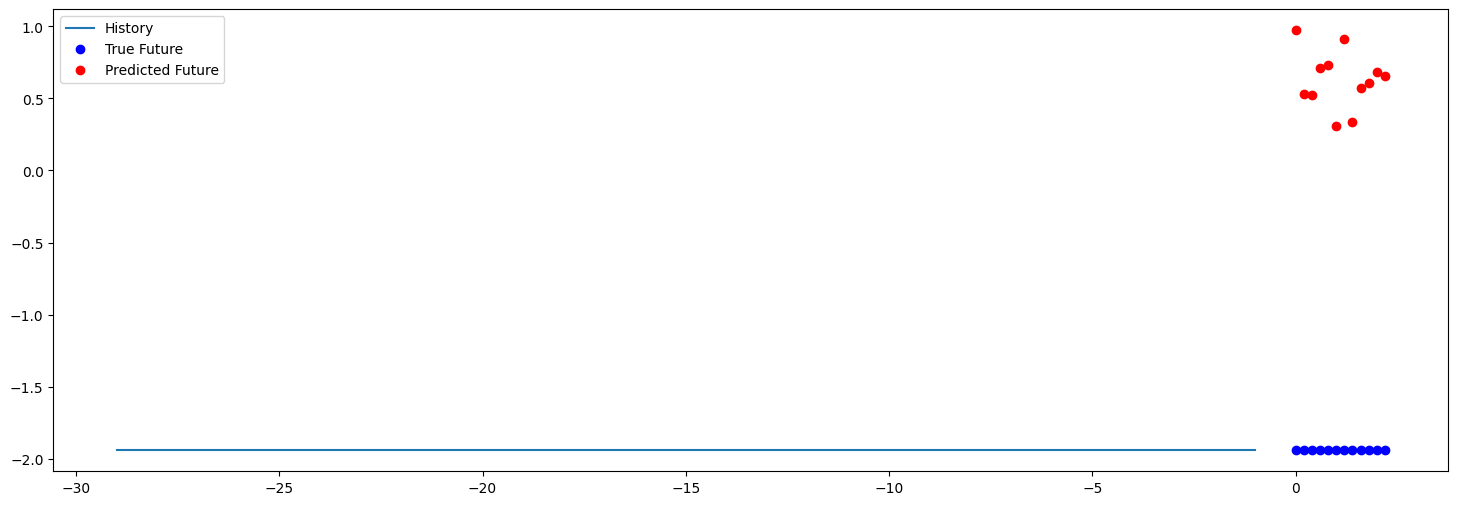

4/4 [==============================] - 0s 3ms/step


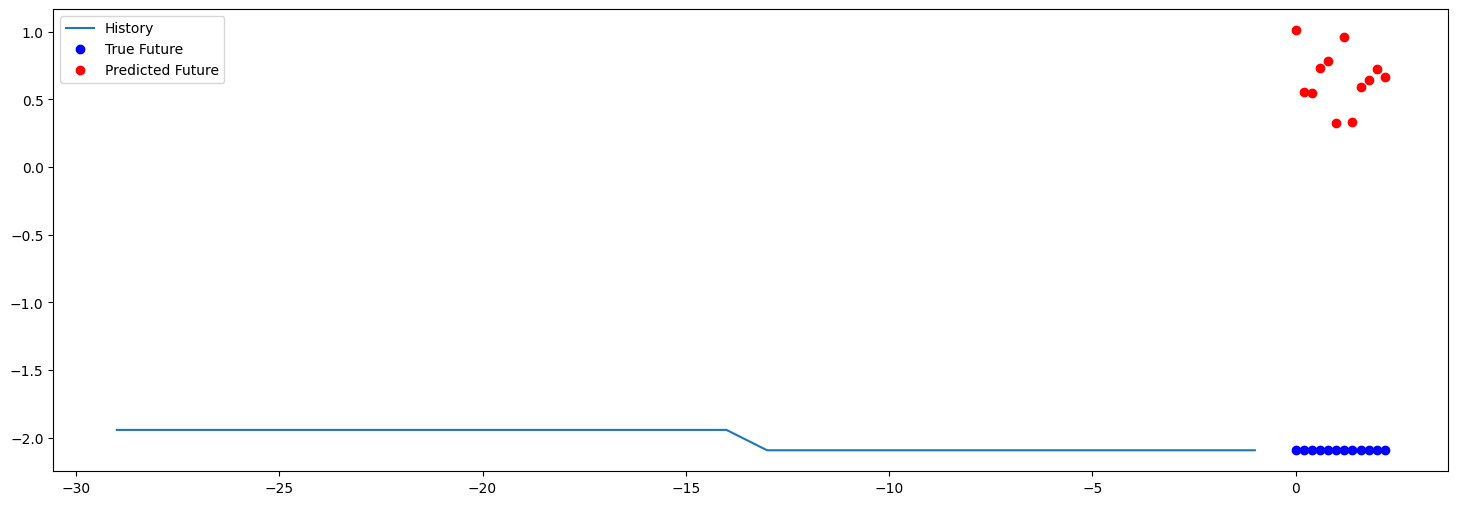

In [24]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [25]:
import tensorflow as tf
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().batch(BATCH_SIZE)
val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE)

predicted_mems = []
original_mems = []
history_mems = []


for x, y in train_data_multi:
    hx_mem = np.squeeze(x[0])
    history_mems.append(hx_mem)

for x, y in val_data_multi:
    prediction = multi_step_model.predict(x, verbose = 0)[0]
    ori_mems = np.squeeze(y[0])
    
    predicted_mems.append(prediction)
    original_mems.append(ori_mems)
    

prediction_mem_usage = np.concatenate(predicted_mems, axis=0)
original_mem_usage = np.concatenate(original_mems, axis=0)
history_mem_usage = np.concatenate(history_mems, axis=0)   

2023-06-12 16:54:26.505268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [2842,12,1]
	 [[{{node Placeholder/_1}}]]
2023-06-12 16:54:26.539038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [591,12,1]
	 [[{{node Placeholder/_1}}]]
2023-06-12 16:54:26.784270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/sp

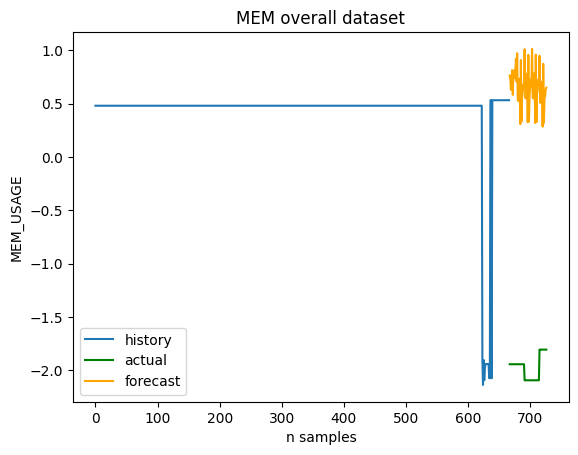

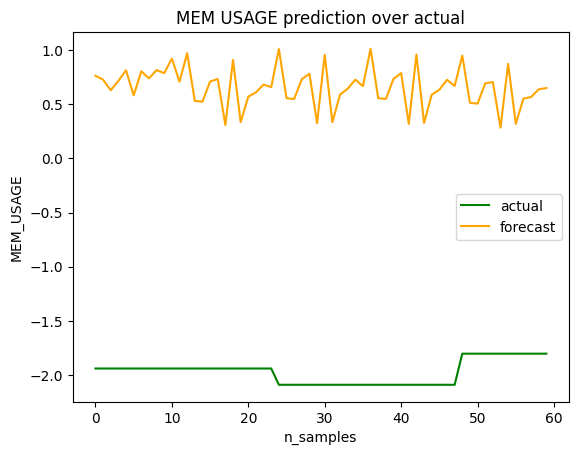

In [26]:
plt.title("MEM overall dataset") 
plt.xlabel("n samples") 
plt.ylabel("MEM_USAGE") 
plt.plot(range(len(history_mem_usage)),history_mem_usage, label="history") 
plt.plot(range(len(history_mem_usage), len(history_mem_usage) + len(prediction_mem_usage)),original_mem_usage, label="actual", color="green") 
plt.plot(range(len(history_mem_usage), len(history_mem_usage) + len(prediction_mem_usage)),prediction_mem_usage, label="forecast", color="orange")

plt.legend()
plt.show()

x = range(len(prediction_mem_usage))
plt.title("MEM USAGE prediction over actual") 
plt.xlabel("n_samples") 
plt.ylabel("MEM_USAGE") 
plt.plot(x,original_mem_usage, label="actual", color="green") 
plt.plot(x,prediction_mem_usage, label="forecast", color="orange")
plt.legend()


In [27]:
my_mean_absolute_percentage_error(original_mem_usage, prediction_mem_usage)

133.4807709972842

# SINGLE FEATURE TEMP

In [28]:
x_train_multi, y_train_multi = multivariate_data(scaled_df[:, 2], scaled_df[:, 2], 0,
                                                 training_size, PAST_WINDOW_SIZE,
                                                 FUTURE_WINDOW_SIZE, STEP)
x_val_multi, y_val_multi = multivariate_data(scaled_df[:, 2], scaled_df[:, 2],
                                             training_size, None, PAST_WINDOW_SIZE,
                                                 FUTURE_WINDOW_SIZE, STEP)


train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(FUTURE_WINDOW_SIZE))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
print(multi_step_model.summary())

early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
multi_step_history = multi_step_model.fit(train_data_multi,
                                          epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=EVALUATION_INTERVAL,
                                          callbacks=[early_stopping])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 29, 32)            4352      
                                                                 
 lstm_5 (LSTM)               (None, 16)                3136      
                                                                 
 dense_2 (Dense)             (None, 12)                204       
                                                                 
Total params: 7,692
Trainable params: 7,692
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10


2023-06-12 16:54:42.950898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 16:54:42.951583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 16:54:42.952241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

197/200 [============================>.] - ETA: 0s - loss: 0.3926

2023-06-12 16:54:47.239259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [591,12,1]
	 [[{{node Placeholder/_1}}]]
2023-06-12 16:54:47.337644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 16:54:47.338318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tenso

200/200 [==============================] - 5s 18ms/step - loss: 0.3911 - val_loss: 0.3620
Epoch 2/10
200/200 [==============================] - 3s 17ms/step - loss: 0.2172 - val_loss: 0.2037
Epoch 3/10
200/200 [==============================] - 3s 17ms/step - loss: 0.1738 - val_loss: 0.1562
Epoch 4/10
200/200 [==============================] - 3s 17ms/step - loss: 0.1466 - val_loss: 0.1414
Epoch 5/10
200/200 [==============================] - 3s 17ms/step - loss: 0.1348 - val_loss: 0.1132
Epoch 6/10
200/200 [==============================] - 3s 17ms/step - loss: 0.1276 - val_loss: 0.1585
Epoch 7/10
200/200 [==============================] - 3s 17ms/step - loss: 0.1174 - val_loss: 0.0817
Epoch 8/10
200/200 [==============================] - 3s 17ms/step - loss: 0.1091 - val_loss: 0.0737
Epoch 9/10
200/200 [==============================] - 3s 17ms/step - loss: 0.1067 - val_loss: 0.0984
Epoch 10/10
200/200 [==============================] - 3s 17ms/step - loss: 0.1007 - val_loss: 0.1621


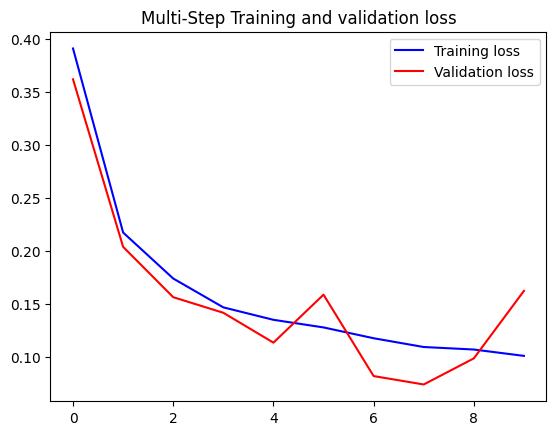

In [29]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [30]:
multi_step_model.save('best_single_feature_temp.h5')

In [31]:
from tensorflow import keras
multi_step_model = keras.models.load_model("./best_single_feature_temp.h5")

2023-06-12 16:55:50.297272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 16:55:50.298173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 16:55:50.298848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-12 16:55:51.604406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [591,12,1]
	 [[{{node Placeholder/_1}}]]
2023-06-12 16:55:51.766474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 16:55:51.767125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tenso

4/4 [==============================] - 0s 6ms/step


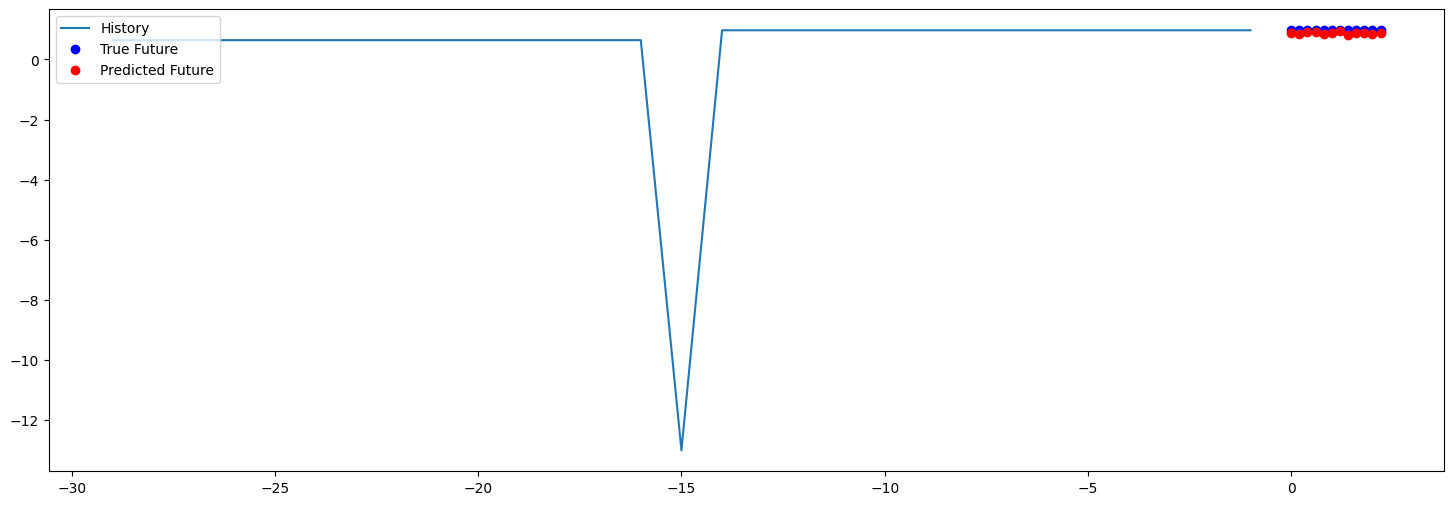

4/4 [==============================] - 0s 3ms/step


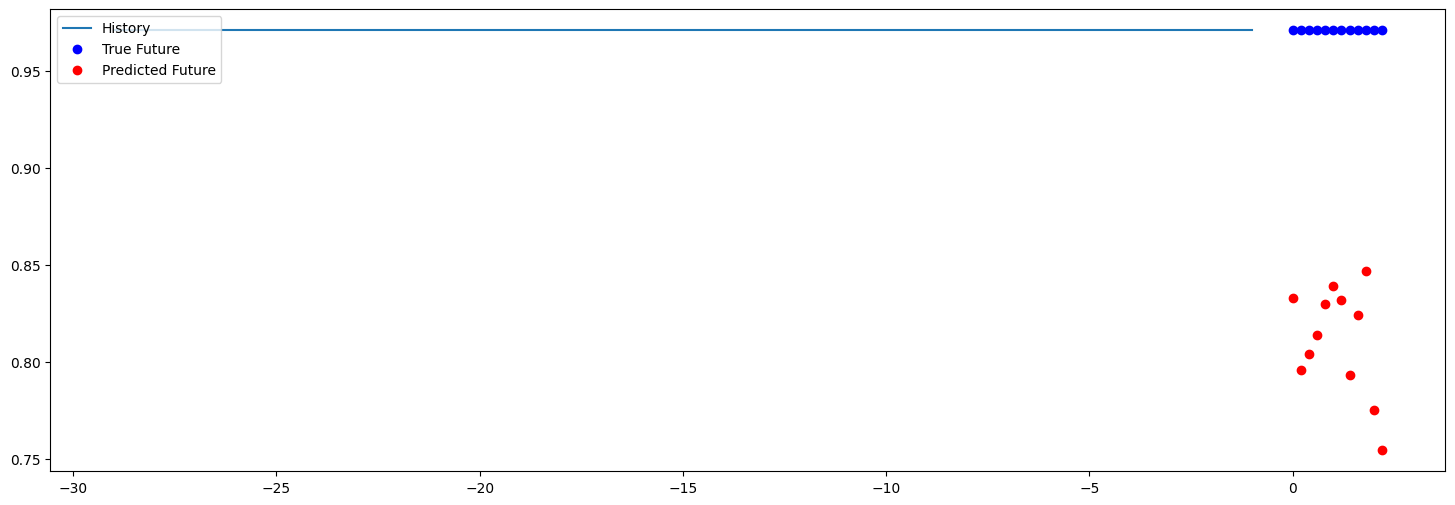

4/4 [==============================] - 0s 4ms/step


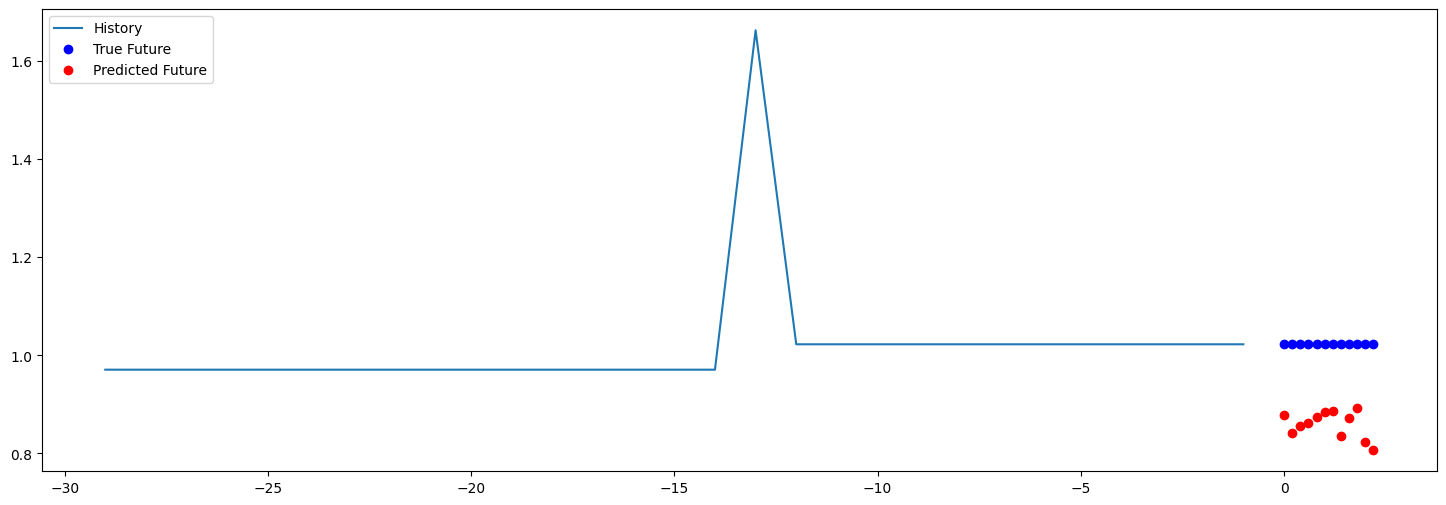

In [32]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [33]:
import tensorflow as tf
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().batch(BATCH_SIZE)
val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE)

predicted_temps = []
original_temps = []
history_temps = []


for x, y in train_data_multi:
    hx_temp = np.squeeze(x[0])
    history_temps.append(hx_temp)

for x, y in val_data_multi:
    prediction = multi_step_model.predict(x, verbose = 0)[0]
    ori_mems = np.squeeze(y[0])
    
    predicted_temps.append(prediction)
    original_temps.append(ori_mems)
    

predicted_temp_usage = np.concatenate(predicted_temps, axis=0)
original_temp_usage = np.concatenate(original_temps, axis=0)
history_temp_usage = np.concatenate(history_temps, axis=0)   

2023-06-12 16:55:53.960365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [2842,12,1]
	 [[{{node Placeholder/_1}}]]
2023-06-12 16:55:53.995710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [591,12,1]
	 [[{{node Placeholder/_1}}]]
2023-06-12 16:55:54.336420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/sp

In [34]:
import tensorflow as tf
val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE)

predicted_temps = []
original_temps = []

for x, y in val_data_multi:
    prediction = multi_step_model.predict(x, verbose = 0 )[0]
    ori_temps = np.squeeze(y[0])
    
    predicted_temps.append(prediction)
    original_temps.append(ori_temps)

prediction_temp_usage = np.concatenate(predicted_temps, axis=0)
original_temp_usage = np.concatenate(original_temps, axis=0)   

2023-06-12 16:56:06.444893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [591,12,1]
	 [[{{node Placeholder/_1}}]]


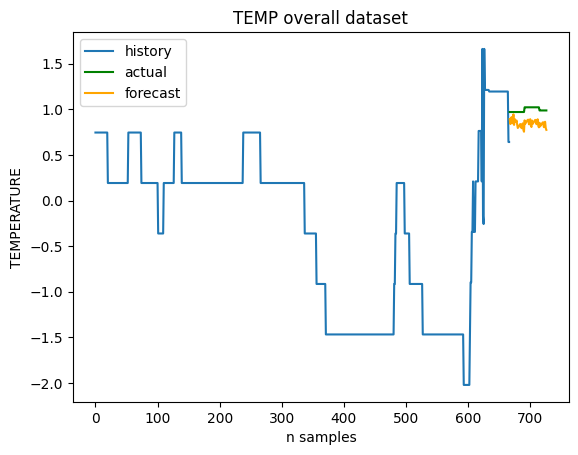

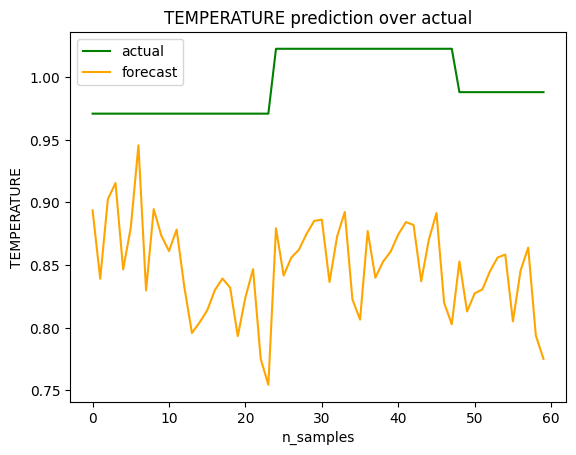

In [35]:
plt.title("TEMP overall dataset") 
plt.xlabel("n samples") 
plt.ylabel("TEMPERATURE") 
plt.plot(range(len(history_temp_usage)),history_temp_usage, label="history") 
plt.plot(range(len(history_temp_usage), len(history_temp_usage) + len(predicted_temp_usage)),original_temp_usage, label="actual", color="green") 
plt.plot(range(len(history_temp_usage), len(history_temp_usage) + len(predicted_temp_usage)),predicted_temp_usage, label="forecast", color="orange")

plt.legend()
plt.show()

x = range(len(predicted_temp_usage))
plt.title("TEMPERATURE prediction over actual") 
plt.xlabel("n_samples") 
plt.ylabel("TEMPERATURE") 
plt.plot(x,original_temp_usage, label="actual", color="green") 
plt.plot(x,predicted_temp_usage, label="forecast", color="orange")
plt.legend()


In [36]:
my_mean_absolute_percentage_error(original_temp_usage, predicted_temp_usage)

14.743022040864654

--------------------

#### Overall the only metrics which reaches a reasonable accuracy is the temperature with 85.3% of accuracy (1-MAPE)